In [1]:
# <1> CPU / GPU
import torch

# 有GPU就用GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# print more information about the cuda device
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0))
# device = "cpu"

Using cuda device
NVIDIA RTX A6000
_CudaDeviceProperties(name='NVIDIA RTX A6000', major=8, minor=6, total_memory=49139MB, multi_processor_count=84, uuid=2c424c11-2d89-e5be-113d-1fa79de7229a, L2_cache_size=6MB)


In [2]:
# <2> 图像文件准备
import os
import shutil

# 输入、输出路径
input_dir  = './raw_data' 
output_dir = "./data"       # 把图像文件分类放到这里

# 创建输出目录output_dir
os.makedirs(output_dir, exist_ok=True)

# 手写汉字个数=15（0~9，个十百千万）
num_classes = 15

# 创建15个汉字类别的对应子目录（0~14）
for i in range(num_classes):
    os.makedirs(f'{output_dir}/{i}', exist_ok=True) 

# 把图像文件分类放到对应的子目录中
for file in os.listdir(input_dir):
    # 根据文件名判断是哪个类别的汉字，如，“零”对应子目录“0”
    category = int(file.split(".")[0].split("_")[-1]) - 1
    # 复制文件到对应的子目录
    shutil.copy2(f"{input_dir}/{file}", f"{output_dir}/{category}")

In [3]:
# <3> 图像数据预处理
import torchvision

# 对Image进行变换，将多个transform变换组合起来
transform = torchvision.transforms.Compose([
    # 将64x64图像转换为32x32像素
    torchvision.transforms.Resize((32, 32)), 
    # 将输入图像转换为张量(tensors), 并归一化至[0, 1]
    torchvision.transforms.ToTensor()]) 

# 将上面的组合变换应用到图像文件中，并生成数据集
dataset = torchvision.datasets.ImageFolder(root=output_dir, transform=transform)

training images: 6144, testing images: 1536


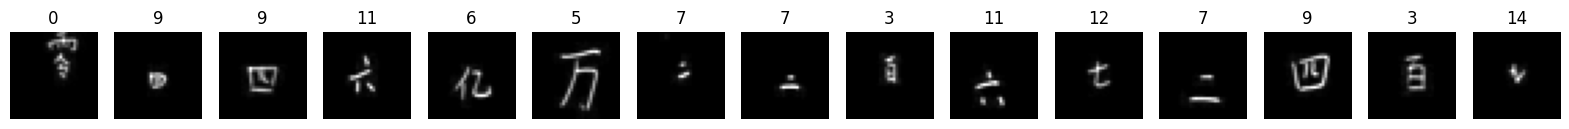

In [4]:
# <4> 数据集划分、加载
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))    # 80% for training
test_size  = len(dataset) - train_size  # 20% for testing

# 随机划分数据集
train_dataset, test_dataset = random_split(dataset, 
                                           [train_size, test_size])

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=True)

# 图像划分后数量、显示部分图像
import matplotlib.pyplot as plt

print(f"training images: {len(train_dataset)}, testing images: {len(test_dataset)}") 
fig = plt.figure(figsize=(20, 5))
for i in range(15):
    img, label = train_dataset[i]
    grayscale_img = img.mean(dim=0) # 将3通道的彩色图像转换为单通道的灰度图像
    ax = fig.add_subplot(1, 15, i + 1)
    ax.axis("off")
    ax.set_title(label)
    ax.imshow(grayscale_img.squeeze().numpy(), cmap="gray")

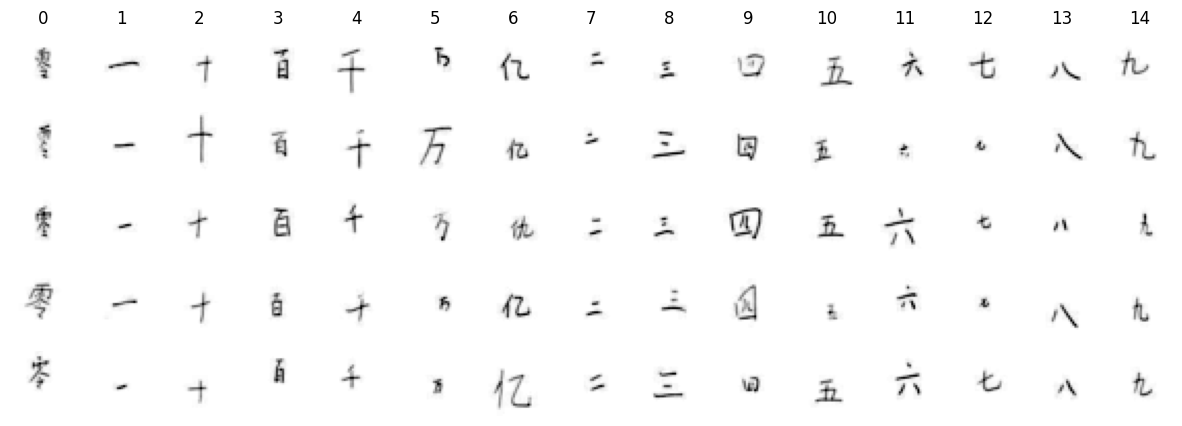

In [5]:
# 绘制5行，每行15个文字
fig = plt.figure(figsize=(15, 5))
idx = 100

for i in range(5):
    for c in range(15):
        img, label = None, None
        while label != c:
            idx += 1
            img, label = train_dataset[idx]
        grayscale_img = img.mean(dim=0)
        ax = fig.add_subplot(5, 15, i * 15 + c + 1)
        ax.axis("off")
        i == 0 and ax.set_title(label)
        # 将灰度图像的像素值反转，变成白底黑字
        ax.imshow(1 - grayscale_img.squeeze().numpy(), cmap="gray")        

In [6]:
# <5> 模型定义、训练、显示
import torch.nn as nn
import torchsummary

# <5-1> 损失函数
criterion = nn.CrossEntropyLoss()

# <5-2> 加载已训练好的Resnet18模型参数（2种方法）
# ============
# 方法1：网上下载 预训练模型
# model = torchvision.models.resnet18(pretrained=True)# 网上下载
# ==== OR ====
# 方法2：加载本地预训练模型
model = torchvision.models.resnet18()
model.load_state_dict(torch.load('./resnet18.pth')) # 硬盘上
# ============

C:\Users\Sean\AppData\Local\Temp\ipykernel_53292\3473404119.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./resnet18.pth')) # 硬盘上


<All keys matched successfully>

In [ ]:
# <5-3> 微调、修改模型结构（多种方法）
# 方法1：修改最后一层, 使其输出15个类别, 而不是1000个
#        其它层不锁定，参与训练。
#        然后训练所有层。
model.fc = nn.Linear(512, 15)

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
# 方法2：修改最后一层, 使其输出15个类别,
#       其它层锁定，不参与训练。
#       然后只训练最后一层。 
model.fc = nn.Linear(512, 15)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
for param in model.parameters():
    # 如果不是fc全连接层的权重和偏置
    if param is not model.fc.weight and param is not model.fc.bias:
        # 不参与训练
        param.requires_grad = False

In [ ]:
# 方法3：修改最后一层, 使其输出15个类别,
#       其它层不锁定，参与训练。同时调整不同层的学习率。
#       然后训练所有层。
model.fc = nn.Linear(512, 15)

# 列表推导式，获取不是fc全连接层的参数
params_1x = [param for name, param in model.named_parameters() 
             if name not in ["fc.weight", "fc.bias"]]
# 优化器
optimizer = torch.optim.Adam([
    {'params': params_1x}, # 不是fc全连接层的参数，学习率低，因已经训练好了
    {'params': model.fc.parameters(), 'lr': 0.0005 * 10} # fc学习率高
    ],     lr=0.0005)

In [7]:
# <5-5> 将模型转移到 CPU / GPU 上
model = model.to(device)

# <5-6> 显示模型结构、参数信息
torchsummary.summary(model, input_size=(3, 32, 32), device=device)
# 输入图像大小为3x32x32, 即3通道, 32x32像素

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [8]:
# <6> 计算正确率函数
def test(model,         # 模型
         data_loader,   # 数据加载器, train_loader或test_loader
         ):
    
    # <6-1> 进入评估模式
    model.eval()

    correct, total = 0, 0
    # <6-2> 计算正确预测个数
    with torch.no_grad():  
        for inputs, labels in tqdm(data_loader, desc="测试", leave=False):
            # 1）用GPU/CPU？
            inputs, labels = inputs.to(device), labels.to(device)

            # 2）前向传播，计算输出
            outputs = model(inputs)

            # 3）计算正确值、总数
            # 按行(=1)取最大值(预测结果)，返回最大值、最大值的索引
            _, predicted = torch.max(outputs, 1)  
            # 累加正确预测的个数
            correct += (predicted == labels).sum().item()
            # 累加总的样本个数
            total   += labels.size(0) # labels.shape[0]

    # 返回正确率
    return correct / total

In [9]:
# <7> 训练模型
from tqdm import tqdm

# 初始化训练过程中的指标：训练精度、测试精度、损失，用于绘图
train_acc_history, test_acc_history, loss_history = [], [], []

def train(model, train_loader):
    # 将模型设置为训练模式，打开dropout等，更新参数，计算梯度
    model.train()  # 训练模式（默认）
    total_loss = 0
    #                          训练数据集     进度条描述    不保留进度条
    for inputs, labels in tqdm(train_loader, desc="训练", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # 1) 向前传播计算结果
        outputs = model(inputs)

        # 2) 计算损失
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # 3) 反向传播
        loss.backward()

        # 4) 更新权重
        optimizer.step()
        optimizer.zero_grad()
    return total_loss / len(train_loader)


num_epochs = 10  # 训练次数
for epoch in range(num_epochs):
    train_loss = train(model, train_loader)  # 训练
    train_acc = test(model, train_loader)  # 测试
    test_acc = test(model, test_loader)  # 测试

    # 更新绘图指标
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    loss_history.append(train_loss)

    # 打印训练信息
    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        + f"Loss: {train_loss:.2f}, "
        + f"Train accuracy: {train_acc_history[-1]:.2f}, "
        + f"Test accuracy:  {test_acc_history[-1]:.2f}"
    )


# 打印最终训练信息
print(f"Final train accuracy: {train_acc_history[-1]:.2f}")
print(f"Final test accuracy: {test_acc_history[-1]:.2f}")

Epoch 1/10, Loss: 0.77, Train accuracy: 0.93, Test accuracy:  0.92


Epoch 2/10, Loss: 0.29, Train accuracy: 0.96, Test accuracy:  0.95


Epoch 3/10, Loss: 0.18, Train accuracy: 0.98, Test accuracy:  0.97


Epoch 4/10, Loss: 0.12, Train accuracy: 0.97, Test accuracy:  0.96


Epoch 5/10, Loss: 0.13, Train accuracy: 0.95, Test accuracy:  0.94


Epoch 6/10, Loss: 0.10, Train accuracy: 0.95, Test accuracy:  0.94


Epoch 7/10, Loss: 0.14, Train accuracy: 0.96, Test accuracy:  0.95


Epoch 8/10, Loss: 0.10, Train accuracy: 0.96, Test accuracy:  0.94


Epoch 9/10, Loss: 0.10, Train accuracy: 0.99, Test accuracy:  0.98


Epoch 10/10, Loss: 0.06, Train accuracy: 0.99, Test accuracy:  0.98
Final train accuracy: 0.99
Final test accuracy: 0.98


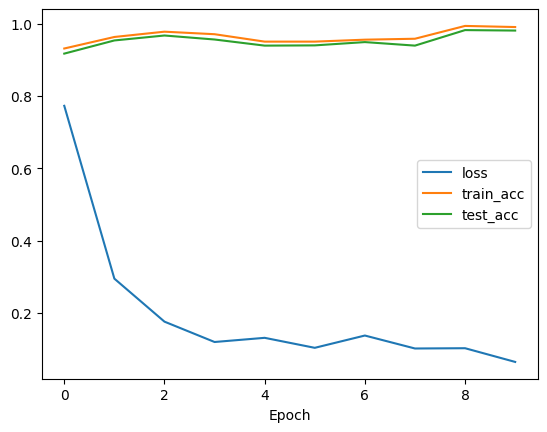

In [10]:
# <8> 绘制训练过程中的指标

# 定义绘制函数
def draw_plot(loss_history, train_acc_history, test_acc_history):
    plt.figure()
    plt.plot(loss_history,      label="loss")
    plt.plot(train_acc_history, label="train_acc")
    plt.plot(test_acc_history,  label="test_acc")
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()
    
# 绘图    
draw_plot(loss_history, train_acc_history, test_acc_history)

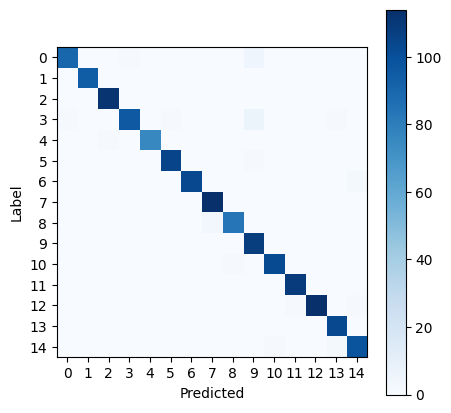

In [11]:
# <9> 模型评估 

# 定义绘制混淆矩阵函数
def draw_confusion_matrix(model, dataloader):
    # 初始化混淆矩阵，大小为类别数x类别数，初始值为0
    confusion_matrix = torch.zeros(num_classes, num_classes)

    # 遍历数据集，计算混淆矩阵
    with torch.no_grad():
        for inputs, labels in dataloader:
            # GPU？
            inputs, labels = inputs.to(device), labels.to(device)
            # 计算输出
            outputs = model(inputs)
            # 获取预测结果
            _, predicted = torch.max(outputs, 1)
            # 更新混淆矩阵
            for t, p in zip(labels.view(-1), predicted.view(-1)): # view(-1)将张量展平(1行多列)，方便逐个元素比较
                # .long()将张量转换为长整型
                confusion_matrix[t.long(), p.long()] += 1

    plt.figure(figsize=(5, 5))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar() # 显示颜色条
    plt.xlabel("Predicted")
    plt.ylabel("Label")
    plt.xticks(range(num_classes))
    plt.yticks(range(num_classes))

# 绘制混淆矩阵
draw_confusion_matrix(model, test_loader)